In [2]:
import numpy as np 
import pandas as pd 
import zipfile
import random
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow import keras
from keras.models import Sequential, Model
from keras.utils import to_categorical
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D, AveragePooling2D
from keras import applications
from keras.applications import VGG16,ResNet50
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


# Load in datasets

In [3]:
import os
print(os.listdir("../input/dogs-vs-cats"))

import zipfile

with zipfile.ZipFile("../input/dogs-vs-cats/train.zip","r") as z:
    z.extractall()
    
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip","r") as z:
    z.extractall()

['test1.zip', 'train.zip', 'sampleSubmission.csv']


# Create labels based on image name

In [4]:
filenames = os.listdir("/kaggle/working/train/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
        

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df['label'] = df['category'].apply(lambda x: 'dog' if x > 0 else 'cat')
df.head()

,filename,category,label
0,cat.12057.jpg,0,cat
1,cat.3742.jpg,0,cat
2,dog.7541.jpg,1,dog
3,cat.4071.jpg,0,cat
4,dog.4728.jpg,1,dog


# Check the balance of the dataset 

In [5]:
dog_count = df['category'].sum()
cat_count = len(df) - dog_count
print('# of dog pics: ', dog_count, '  # of cat pics: ', cat_count)

# of dog pics:  12500   # of cat pics:  12500


In [6]:
dogs = df[df['category']==1].reset_index(drop = True)
cats = df[df['category']==0].reset_index(drop = True)

In [7]:
dog_samples = random.choices(dogs['filename'], k = 9)
cat_samples = random.choices(cats['filename'], k = 9)
print(dog_samples)
print(cat_samples)

['dog.9299.jpg', 'dog.12154.jpg', 'dog.5648.jpg', 'dog.5346.jpg', 'dog.7998.jpg', 'dog.7868.jpg', 'dog.250.jpg', 'dog.6718.jpg', 'dog.10882.jpg']
['cat.3232.jpg', 'cat.2636.jpg', 'cat.1371.jpg', 'cat.6823.jpg', 'cat.12080.jpg', 'cat.4876.jpg', 'cat.930.jpg', 'cat.3011.jpg', 'cat.5011.jpg']


# Display sample images from 2 classes

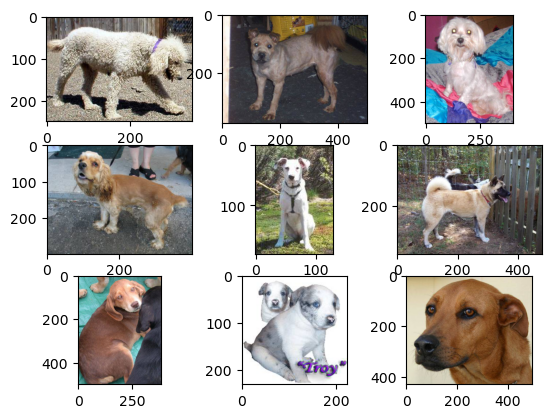

In [8]:
for i, j in enumerate (dog_samples):
    plt.subplot(3,3, 1 + i)
    plt.rcParams["figure.figsize"] = (5,5)
    file = "/kaggle/working/train/" + j
    image = imread(file)
    plt.imshow(image)
# show the figure
plt.show()


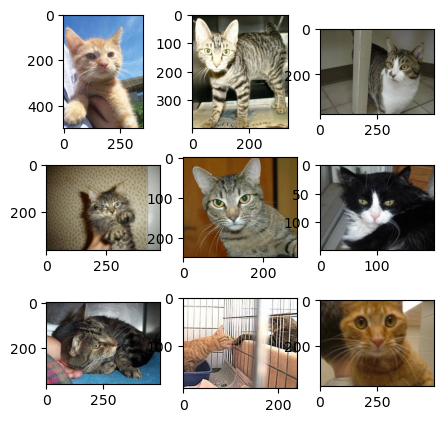

In [9]:
for i, j in enumerate (cat_samples):
    plt.subplot(3,3, 1 + i)
    plt.rcParams["figure.figsize"] = (5,5)
    file = "/kaggle/working/train/" + j
    image = imread(file)
    plt.imshow(image)
# show the figure
plt.show()

# Prepare training dataset

In [10]:
train_df, validate_df = train_test_split(df, test_size=0.2)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [11]:
train_df

,index,filename,category,label
0,23533,cat.2889.jpg,0,cat
1,9974,cat.6620.jpg,0,cat
2,13080,dog.9056.jpg,1,dog
3,17706,cat.7033.jpg,0,cat
4,11337,dog.9554.jpg,1,dog
...,...,...,...,...
19995,2069,dog.4533.jpg,1,dog
19996,7557,cat.12214.jpg,0,cat
19997,1986,dog.4762.jpg,1,dog
19998,17091,dog.4861.jpg,1,dog


# Data augmentation to reduce overfitting

In [12]:
image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 3
batch_size = 32

In [82]:
def get_data(dataset):
    if dataset == 'train':
        train_generator = ImageDataGenerator(
            rotation_range=15,
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            width_shift_range=0.1,
            height_shift_range=0.1
        )

        train_data = train_generator.flow_from_dataframe(
            train_df, 
            "/kaggle/working/train/", 
            x_col='filename',
            y_col='label',
            class_mode='binary',
            target_size=(image_size, image_size),
            batch_size=batch_size,
            shuffle=False
        )
        return train_generator, train_data
    elif dataset == 'valid':
        valid_generator = ImageDataGenerator(rescale=1./255)
        valid_data = valid_generator.flow_from_dataframe(
            validate_df, 
            "/kaggle/working/train/", 
            x_col='filename',
            y_col='label',
            class_mode='binary',
            target_size=(image_size, image_size),
            batch_size=batch_size,
            shuffle=False
        )
        return valid_generator, valid_data
    elif dataset == 'test':
        test_generator = ImageDataGenerator(rescale=1./255)
        test_data = test_generator.flow_from_dataframe(
            test_df, 
            "/kaggle/working/test1/", 
            x_col='filename',
            y_col=None,
            class_mode=None,
            batch_size=batch_size,
            target_size=(image_size, image_size),
            shuffle=False
        )
        return test_generator, test_data

In [83]:
train_generator, train_data = get_data('train')

Found 20000 validated image filenames belonging to 2 classes.


In [27]:
valid_generator, valid_data = get_data('valid')

Found 5000 validated image filenames belonging to 2 classes.


# Check generated images

Found 1 validated image filenames.


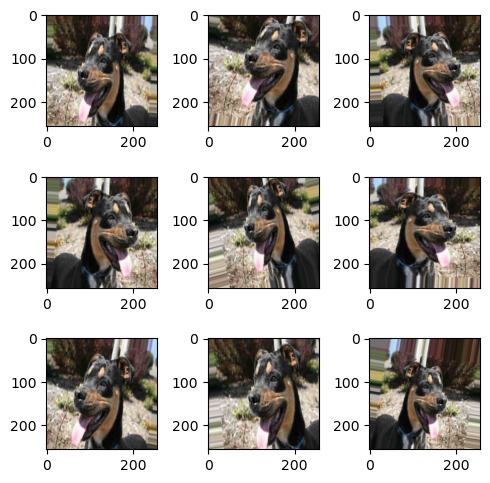

In [30]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_generator.flow_from_dataframe(
    example_df, 
    "/kaggle/working/train/", 
    x_col='filename',
    y_col='label',
    class_mode='raw'
)
plt.figure(figsize=(5, 5))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Function for plotting results

In [31]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
#     axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
#     axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    

# CNN 

In [76]:
CNN = Sequential()
# Adds a densely-connected layer with 64 units to the model:
CNN.add(Conv2D(64,(3,3), activation = 'relu', input_shape = input_shape))
CNN.add(MaxPooling2D(pool_size = (2,2)))
# Add another:
CNN.add(Conv2D(64,(3,3), activation = 'relu'))
CNN.add(MaxPooling2D(pool_size = (2,2)))

CNN.add(Flatten())
CNN.add(Dense(64, activation='relu'))
# Add a softmax layer with 10 output units:
CNN.add(Dense(1, activation='sigmoid'))

CNN.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [78]:
history = CNN.fit(
    train_data,
    epochs=epochs,
    validation_data=valid_data,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/3
625/625 [==============================] - 268s 424ms/step - loss: 0.6898 - accuracy: 0.5832 - val_loss: 0.6421 - val_accuracy: 0.6384
Epoch 2/3
625/625 [==============================] - 262s 420ms/step - loss: 0.6475 - accuracy: 0.6338 - val_loss: 0.6220 - val_accuracy: 0.6613
Epoch 3/3
625/625 [==============================] - 264s 423ms/step - loss: 0.6244 - accuracy: 0.6571 - val_loss: 0.5888 - val_accuracy: 0.6905


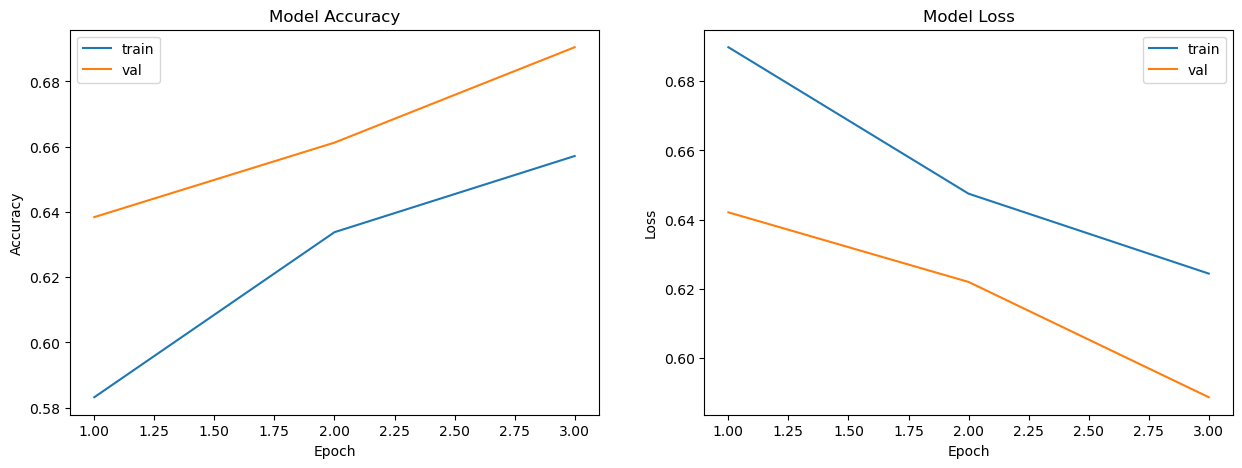

In [79]:
plot_model_history(history)

# Pretain (VGG16)

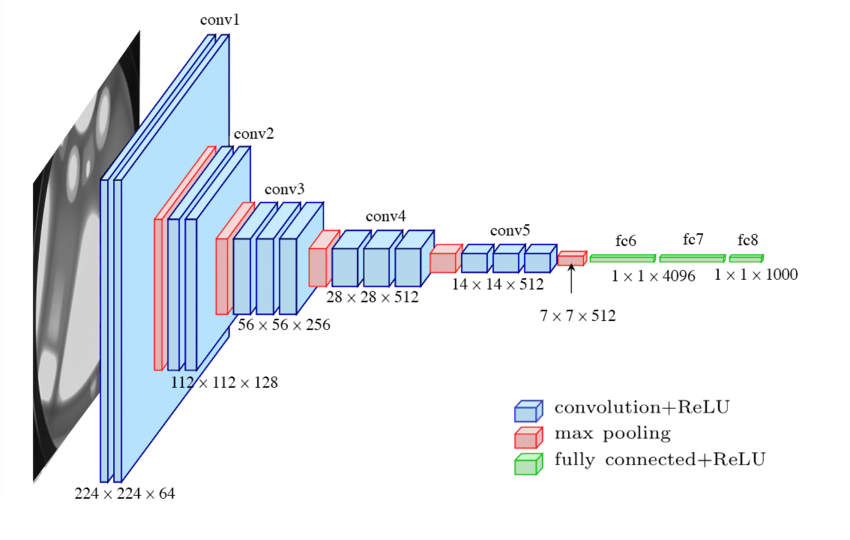

In [32]:
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")    
pre_trained_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [33]:
for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [46]:
# fine-tune the model
history = model.fit(
    train_data,
    epochs=5,
    validation_data=valid_data,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/5
625/625 [==============================] - 285s 456ms/step - loss: 0.4682 - accuracy: 0.7774 - val_loss: 0.3474 - val_accuracy: 0.8762
Epoch 2/5
625/625 [==============================] - 276s 441ms/step - loss: 0.4111 - accuracy: 0.8165 - val_loss: 0.3149 - val_accuracy: 0.8844
Epoch 3/5
625/625 [==============================] - 280s 448ms/step - loss: 0.3864 - accuracy: 0.8263 - val_loss: 0.2957 - val_accuracy: 0.8874
Epoch 4/5
625/625 [==============================] - 278s 445ms/step - loss: 0.3600 - accuracy: 0.8448 - val_loss: 0.2811 - val_accuracy: 0.8898
Epoch 5/5
625/625 [==============================] - 279s 446ms/step - loss: 0.3506 - accuracy: 0.8468 - val_loss: 0.2701 - val_accuracy: 0.8936


In [47]:
history.history

{'loss': [0.4681709408760071,
  0.4110705554485321,
  0.3863847553730011,
  0.36004263162612915,
  0.35058483481407166],
 'accuracy': [0.7773500084877014,
  0.8165000081062317,
  0.8262500166893005,
  0.8447999954223633,
  0.846750020980835],
 'val_loss': [0.34744882583618164,
  0.31493574380874634,
  0.2957027852535248,
  0.28105685114860535,
  0.27014878392219543],
 'val_accuracy': [0.8762019276618958,
  0.8844150900840759,
  0.8874198794364929,
  0.8898237347602844,
  0.893629789352417]}

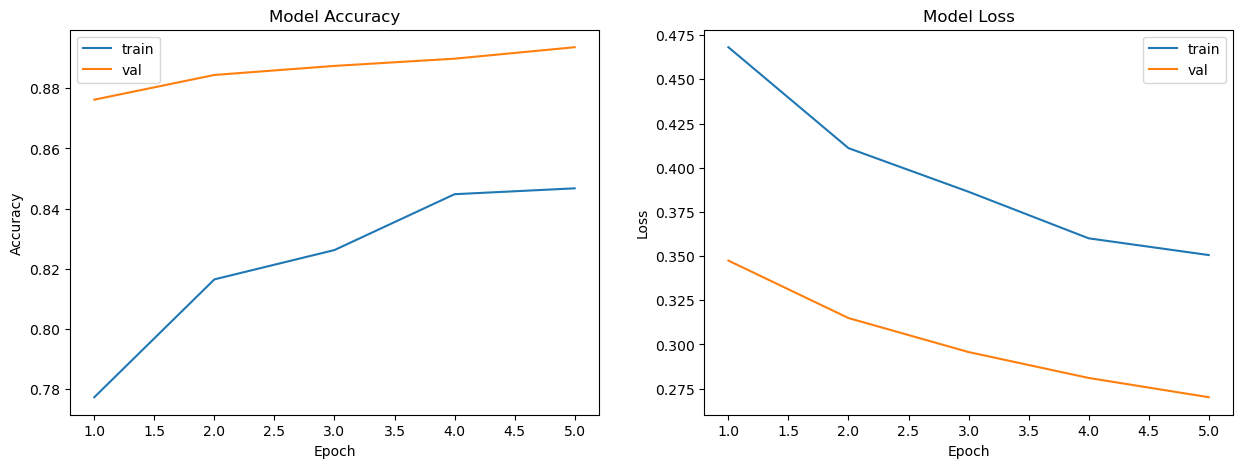

In [49]:
plot_model_history(history)

In [51]:
valid_eval = model.evaluate(valid_data,steps=np.ceil(total_validate/batch_size))

157/157 [==============================] - 19s 119ms/step - loss: 0.2702 - accuracy: 0.8936


In [52]:
valid_pred = model.predict_generator(valid_data, steps=np.ceil(total_validate/batch_size), verbose=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


157/157 [==============================] - 18s 115ms/step


In [87]:
valid_data.classes == validation_generator.classes

True

In [53]:
true_label = validation_generator.classes
print(true_label[:5])
print(valid_pred[:5])

[1, 1, 1, 0, 1]
[[0.94127417]
 [0.48097754]
 [0.24219824]
 [0.15142253]
 [0.9259861 ]]


In [54]:
valid_df = pd.DataFrame(validation_generator.classes, columns = ['class'])
valid_df['predict_proba'] = valid_pred
valid_df['prediction'] = valid_df['predict_proba'].apply(lambda x: 1 if x > 0.5 else 0)
valid_df

,class,predict_proba,prediction
0,1,0.941274,1
1,1,0.480978,0
2,1,0.242198,0
3,0,0.151423,0
4,1,0.925986,1
...,...,...,...
4995,1,0.549167,1
4996,0,0.100993,0
4997,1,0.717515,1
4998,0,0.504495,1


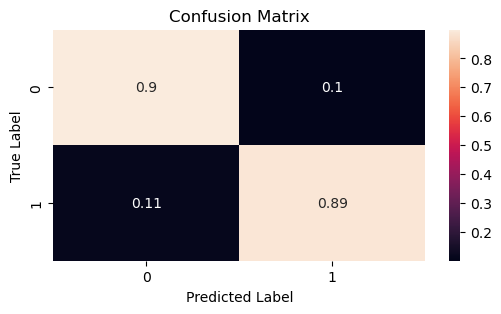

In [55]:
confusion_mtx = confusion_matrix(valid_df['class'], valid_df['prediction'], normalize='true') 

f,ax = plt.subplots(figsize=(6, 3))
sns.color_palette("vlag", as_cmap=True)
sns.heatmap(confusion_mtx, annot=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# K-fold cross validation

In [56]:
def train_and_cross_validate (model, x_data, y_data, n_folds=5, epochs=1, batch_size= 32):
    # 
    scores = []
    
    #  Loading images through generators ...
    train_generator = ImageDataGenerator(rotation_range=15,
                                        rescale=1./255,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest',
                                        width_shift_range=0.1,
                                        height_shift_range=0.1) 

    validation_generator = ImageDataGenerator(rescale=1. / 255)
          
    # prepare cross validation
    kfold = sk.model_selection.KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    FoldsSetNo = 1 
    for train_ix, test_ix in kfold.split(x_data):
        print ('Fold #{0}'.format(FoldsSetNo))
        # select rows for train and test
        xx_train, yy_train, xx_test, yy_test = \
            x_data[train_ix], y_data[train_ix], x_data[test_ix], y_data[test_ix]

        # flow training images in batches for the current folds set
        # for training         
        train_data = train_generator.flow_from_dataframe(
            dataframe = pd.DataFrame({'id':xx_train,'label':yy_train}), 
            directory="/kaggle/working/train/", 
            x_col='id',
            y_col='label',
            batch_size=batch_size,
            target_size=(image_size, image_size),
            class_mode='binary', 
            shuffle = False)
        
        # for validation         
        valid_data = validation_generator.flow_from_dataframe(
            dataframe = pd.DataFrame({'id':xx_test,'label':yy_test}), 
            directory="/kaggle/working/train/", 
            x_col='id',
            y_col='label',
            batch_size=batch_size,
            target_size=(image_size, image_size),
            class_mode='binary',
            shuffle=False)


        
        # fit the model
        history = model.fit(train_data,
                            epochs=epochs,  # The more we train the more our model fits the data
                            batch_size=batch_size,  # Smaller batch sizes = samller steps towards convergence
                            validation_data=valid_data,
                            verbose=1)
        # store scores
        scores.append({'acc':np.average(history.history['accuracy']),'val_acc':np.average(history.history['val_accuracy'])})
        FoldsSetNo +=1
    return scores

In [58]:
scores = train_and_cross_validate(model, train_df['filename'], train_df['label'])

Fold #1
Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.
500/500 [==============================] - 221s 443ms/step - loss: 0.3462 - accuracy: 0.8478 - val_loss: 0.2622 - val_accuracy: 0.9000
Fold #2
Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.
500/500 [==============================] - 219s 438ms/step - loss: 0.3319 - accuracy: 0.8567 - val_loss: 0.2571 - val_accuracy: 0.9018
Fold #3
Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.
500/500 [==============================] - 218s 436ms/step - loss: 0.3293 - accuracy: 0.8555 - val_loss: 0.2448 - val_accuracy: 0.9095
Fold #4
Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.
500/500 [==============================] - 221s 442ms/step - loss: 0.32

In [75]:
sum([scores[i]['val_acc'] for i in range(5)])/5

0.8997000098228455

# Prepare Testing Data

In [80]:
test_filenames = os.listdir("/kaggle/working/test1")

test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
print(test_df.shape)
test_df.head()

(12500, 1)


,filename
0,2679.jpg
1,5925.jpg
2,5261.jpg
3,3081.jpg
4,2257.jpg


In [84]:
# Create Testing Generator
test_generator, test_data = get_data('test')

Found 12500 validated image filenames.


# Prepare test prediction for submition

In [88]:
test_predict = model.predict_generator(test_data, steps=np.ceil(test_df.shape[0]/batch_size), verbose=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


391/391 [==============================] - 46s 117ms/step


In [90]:
predict_df = test_df.copy()
predict_df['id'] = predict_df['filename'].str.split('.').str[0]
predict_df['predict'] = test_predict
predict_df['label'] = predict_df['predict'].apply(lambda x: 0 if x < 0.5 else 1)
predict_df['category'] = predict_df['label'].apply(lambda x: 'dog' if x == 1 else 'cat')
predict_df

,filename,id,predict,label,category
0,2679.jpg,2679,0.512802,1,dog
1,5925.jpg,5925,0.976683,1,dog
2,5261.jpg,5261,0.060657,0,cat
3,3081.jpg,3081,0.204388,0,cat
4,2257.jpg,2257,0.309398,0,cat
...,...,...,...,...,...
12495,12405.jpg,12405,0.244333,0,cat
12496,1757.jpg,1757,0.399530,0,cat
12497,8500.jpg,8500,0.039313,0,cat
12498,3810.jpg,3810,0.997377,1,dog


In [91]:
predict_df['label'].sum()

6354

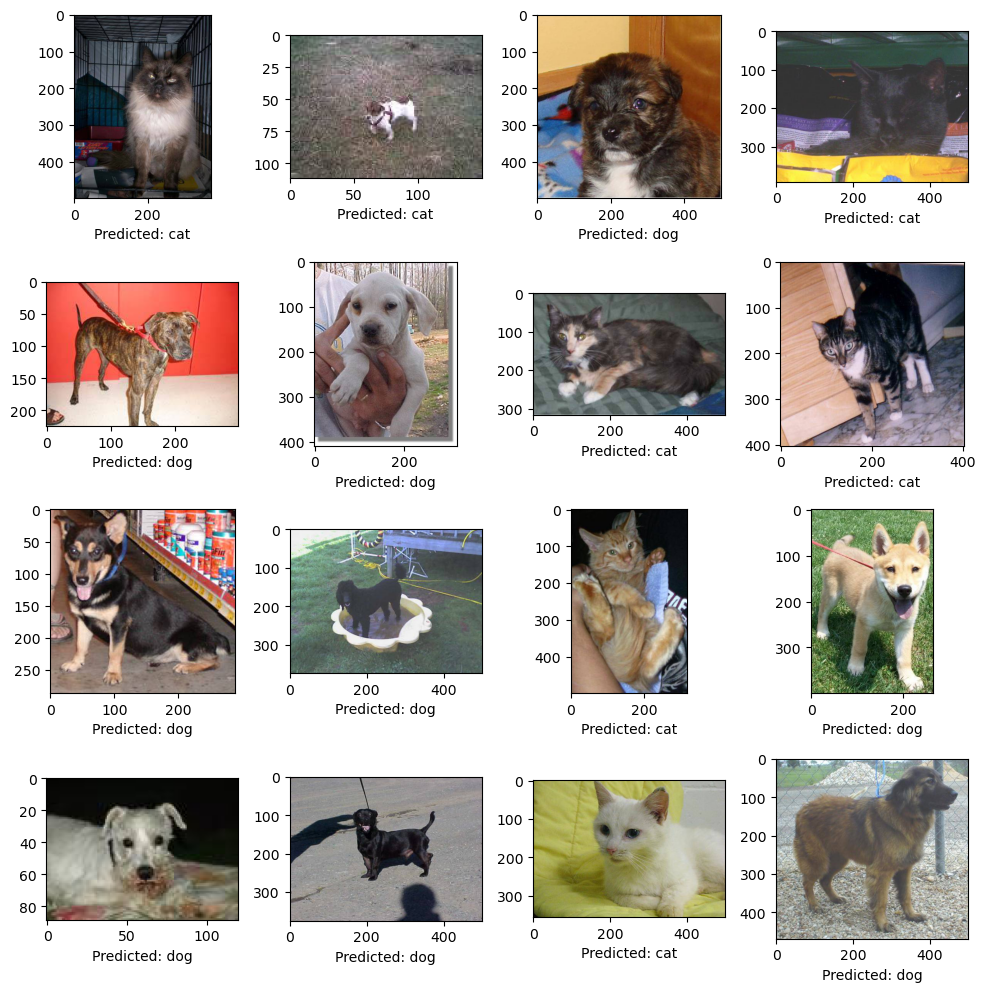

In [94]:
sample_test = predict_df.values[np.random.randint(0, len(test_predict), 16)]
sample_test
plt.figure(figsize=(10,10))
for index, row in enumerate(sample_test):
    filename = row[0]
    category = row[-1]
    image = imread("./test1/"+filename)
    plt.subplot(4, 4, index+1)
    plt.imshow(image)
    plt.xlabel('Predicted: ' + "{}".format(category) )
plt.tight_layout()
plt.show()


In [96]:
submit = predict_df.copy()
submit.drop(['filename', 'predict', 'category'], axis=1, inplace=True)
submit.to_csv('submission.csv')